In [1]:
import pickle
import json
import pandas as pd
from tqdm import tqdm
import matplotlib.pyplot as plt
import diff_utils
from search_anchor import heuristic_search
from utils import overlap_metrixv2, cos_sim, diffsim
import numpy as np

In [9]:
def get_scores(data, semantics, tag=''):
    code_change_list = [' '.join(diff_utils.compute_minimal_comment_diffs(data['old_code'][i].split(),data['new_code'][i].split())[0]) for i in range(len(data))]
    comm_change_list = [' '.join(diff_utils.compute_minimal_comment_diffs(data['old_comment'][i].split(),data['new_comment'][i].split())[0]) for i in range(len(data))]
    sim_cosin_token_comm = []
    sim_cosin_token_code = []
    sim_cosin_sent_comm = []
    gap_list = []
    index_d_list = []
    index_o_list =[]
    for i in tqdm(range(len(data))):
        comm_sim = cos_sim(semantics['semantics_comm_1'][i],semantics['semantics_comm_2'][i])
        code_sim = cos_sim(semantics['semantics_code_1'][i],semantics['semantics_code_2'][i])
        comm_sentsim = cos_sim(semantics['sent_semantics_comm_1'][i],semantics['sent_semantics_comm_2'][i])
        sim_cosin_token_comm.append(comm_sim)
        sim_cosin_token_code.append(code_sim)
        sim_cosin_sent_comm.append(comm_sentsim)

        gap = 1-abs(cos_sim(semantics['semantics_comm_1'][i],semantics['semantics_comm_2'][i]) - \
                    cos_sim(semantics['semantics_code_1'][i],semantics['semantics_code_2'][i]))
        gap_list.append(gap)
    
        # long_comm = len(data.old_comment[i].strip().split()) >=3 and len(data.new_comment[i].strip().split()) >=3
        if tag=='aaai21':
            long_comm = len(data.old_comment[i].strip().split()) >=3 and len(data.new_comment[i].strip().split()) >=3
        else:
            long_comm = len(data.old_comment[i].strip().split()) >=2 and len(data.new_comment[i].strip().split()) >=2
        d = diffsim(semantics['semantics_diff_code'][i],semantics['semantics_diff_comm'][i], long_comm)
        # d = cos_sim(semantics['semantics_diff_code'][i],semantics['semantics_diff_comm'][i])
        
        o = overlap_metrixv2(comm_change_list[i], code_change_list[i], long_comm)
        index_d_list.append(d)
        index_o_list.append(o)
    # c11
    scores = []
    usings = []
    all_scores = []
    diffc11 = []
    for i in tqdm(range(len(data))):
        dc = index_d_list[i]*max(sim_cosin_token_comm[i], sim_cosin_token_code[i])
        og = og = index_o_list[i]*max(sim_cosin_token_comm[i], sim_cosin_token_code[i])
        cc = sim_cosin_token_code[i]*sim_cosin_sent_comm[i]*sim_cosin_token_comm[i]
        indexs = [cc, dc, og]
        score = max(cc, dc, og)
        all_scores.append(indexs)
        using = indexs.index(score)
        scores.append(max(cc, dc, og))
        usings.append(using)
        if i == 775:
            print([cc,dc,og])
            print(score)
        diffc11.append(score)
    print(usings.count(0),usings.count(1),usings.count(2))

    data['score'] = scores
    data['using'] = usings
    df = data.sort_values(by="score", ascending=True) 
    df[['old_comment', 'new_comment', 'old_code', 'new_code','split', 'using', 'score']].to_excel(f'./CaseStudy/{tag}-scores.xlsx')

    plt.hist(scores, color = 'gray', bins=100)
    # plt.title('scores')
    plt.savefig(f'{tag}.jpg', dpi=300)
    plt.show()
    
    return diffc11

In [3]:
def refine_data(data, scores, anchor, tgt_dir):
    print(tgt_dir)
    print(anchor)
    assert len(data) == len(scores)
    keep = []
    score = []
    for i in range(len(data)):
        score.append(scores[i])
        if scores[i]<anchor:
            keep.append(0)
        else:
            keep.append(1)
    data['keep'] = keep
    data['score'] = score
    data_cleaned = data.loc[data.keep==1]
    data_noising = data.loc[data.keep==0]
    train_cleaned = data_cleaned.loc[data_cleaned.split=='train']
    valid_cleaned = data_cleaned.loc[data_cleaned.split=='valid']

    with open(f"{tgt_dir}/train_cleaned.json",'w+') as t:
        for i in tqdm(range(len(train_cleaned))):
            item = train_cleaned.iloc[i,:].to_dict()
            t.write(json.dumps(item)+'\n')
    with open(f"{tgt_dir}/valid_cleaned.json",'w+') as t:
        for i in tqdm(range(len(valid_cleaned))):
            item = valid_cleaned.iloc[i,:].to_dict()
            t.write(json.dumps(item)+'\n')
    with open(f"{tgt_dir}/data_noising.json",'w+') as t:
        for i in tqdm(range(len(data_noising))):
            item = data_noising.iloc[i,:].to_dict()
            t.write(json.dumps(item)+'\n')

100%|██████████| 6503/6503 [00:00<00:00, 478661.34it/s]


[0.7414804569816736, 0.97499450405819, 0.9749945040596458]
0.9749945040596458
1137 2154 3212


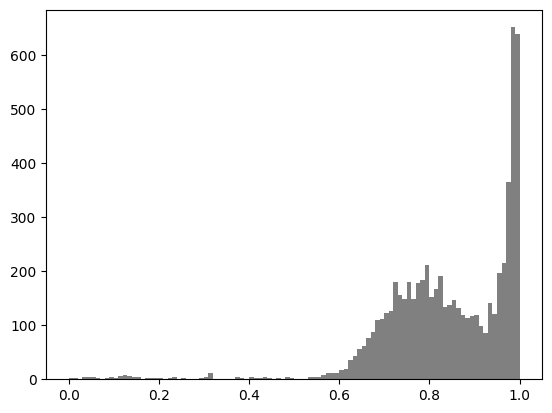

gcbgcb01
Lambda num: 2
Avg, std and var:  0.8401260695576238 0.14503218014515523 0.021034333277656758
New anchor:  0.6414319827587611  Area of this anchor:  0.04920805781946794
(0.04920805781946794, 0.039673996616946025, 0.009534061202521912)
remove rate:  0.04920805781946794
gcbgcb02
Lambda num: 2
Avg, std and var:  0.8401260695576238 0.14503218014515523 0.021034333277656758
New anchor:  0.680590671397953  Area of this anchor:  0.09288020913424573
(0.09288020913424573, 0.07304321082577273, 0.019836998308473006)
remove rate:  0.09288020913424573
gcbgcb03
Lambda num: 2
Avg, std and var:  0.8401260695576238 0.14503218014515523 0.021034333277656758
New anchor:  0.722650003640048  Area of this anchor:  0.17099800092265108
(0.17099800092265108, 0.14101184068891282, 0.029986160233738263)
remove rate:  0.17099800092265108
gcbgcb04
Lambda num: 2
Avg, std and var:  0.8401260695576238 0.14503218014515523 0.021034333277656758
New anchor:  0.7835635193010133  Area of this anchor:  0.32707980931877

In [10]:
comm = 'gcb'
code = 'gcb'
tgt_dir = './CodeT5/data/comment_update/ACL20/'
split = ['train','valid']
length = []
items = []
data = pd.DataFrame()
for s in split:
    temp = pd.read_json(f'../ACL20/comment_update/{s}.json')
    data = pd.concat([data, temp])
    length.append(len(temp))
data.reset_index(drop=True, inplace=True)
data['split'] = ['train']*length[0]+['valid']*length[1]

with open(f"acl20_semanticsv2.pkl",'rb') as sf:
    semantics = pickle.load(sf)

scores = get_scores(data, semantics,'acl20')


score_list = scores
thresholds = [0.01,0.02,0.03,0.04,0.05,0.06,0.07,0.08,0.09,0.1]

for threshold in thresholds:
    threshold_tag = str(threshold)[str(threshold).index('.')+1:]
    tag = comm+code+threshold_tag
    print(tag)
    a = heuristic_search(score_list, threshold)
    if a == 0.0:
        break
    print('remove rate: ',len([s for s in score_list if s < a])/len(score_list))
threshold = thresholds[thresholds.index(threshold)-1]

In [5]:
for threshold in [0.04]:
    m_values = heuristic_search(scores, threshold)
    refine_data(data, scores, m_values, tgt_dir)

Lambda num: 2
Avg, std and var:  0.8401260695576238 0.14503218014515523 0.021034333277656758
New anchor:  0.7835635193010133  Area of this anchor:  0.32707980931877595
(0.32707980931877595, 0.2872520375211441, 0.03982777179763186)
./CodeT5/data/comment_update/ACL20/
0.7835635193010133


100%|██████████| 2127/2127 [00:00<00:00, 2914.39it/s]


100%|██████████| 18372/18372 [00:00<00:00, 445876.72it/s]


[0.7454093188526258, 0.6807598705548038, 0.597592930965607]
0.7454093188526258
4413 3140 10819


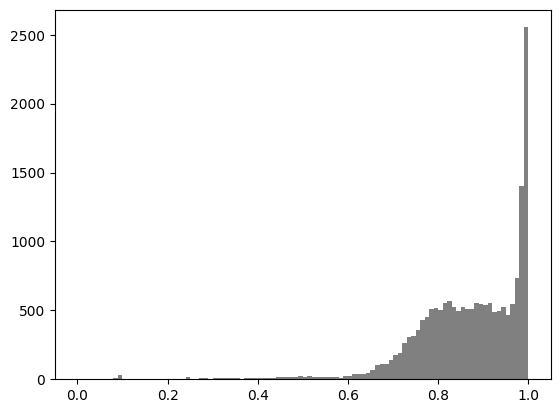

gcbgcb01
Lambda num: 2
Avg, std and var:  0.864969849004257 0.12628418445636214 0.0159476952438085
New anchor:  0.7008004092109862  Area of this anchor:  0.06814718049205312
(0.06814718049205312, 0.05900283039407794, 0.009144350097975179)
remove rate:  0.06814718049205312
gcbgcb02
Lambda num: 2
Avg, std and var:  0.864969849004257 0.12628418445636214 0.0159476952438085
New anchor:  0.7374228227033313  Area of this anchor:  0.11376006967123885
(0.11376006967123885, 0.09400174178097104, 0.01975832789026781)
remove rate:  0.11376006967123885
gcbgcb03
Lambda num: 2
Avg, std and var:  0.864969849004257 0.12628418445636214 0.0159476952438085
New anchor:  0.7702567106619854  Area of this anchor:  0.17924014805138253
(0.17924014805138253, 0.14995645547572392, 0.029283692575658604)
remove rate:  0.17924014805138253
gcbgcb04
Lambda num: 2
Avg, std and var:  0.864969849004257 0.12628418445636214 0.0159476952438085


In [11]:
comm = 'gcb'
code = 'gcb'
tgt_dir = './CodeT5/data/comment_update/AAAI21/'
split = ['train','valid']
length = []
items = []
data = pd.DataFrame()
for s in split:
    temp = pd.read_json(f'./AAAI21/dataset/{s}.json')
    data = pd.concat([data, temp])
    length.append(len(temp))
data.reset_index(drop=True, inplace=True)
data['split'] = ['train']*length[0]+['valid']*length[1]
data = data.rename(columns={'old_comment_raw':'old_comment',"new_comment_raw":"new_comment",\
                            "old_code_raw":"old_code", "new_code_raw":"new_code" })

with open(f"aaai21_semanticsv2.pkl",'rb') as sf:
    semantics = pickle.load(sf)

scores = get_scores(data, semantics, 'aaai21')


score_list = scores
thresholds = [0.01,0.02,0.03,0.04,0.05,0.06,0.07,0.08,0.09,0.1]

for threshold in thresholds:
    threshold_tag = str(threshold)[str(threshold).index('.')+1:]
    tag = comm+code+threshold_tag
    print(tag)
    a = heuristic_search(score_list, threshold)
    if a == 0.0:
        break
    print('remove rate: ',len([s for s in score_list if s < a])/len(score_list))
threshold = thresholds[thresholds.index(threshold)-1]

In [7]:
for threshold in [0.03]:
    m_values = heuristic_search(scores, threshold)
    refine_data(data, scores, m_values, tgt_dir)

Lambda num: 2
Avg, std and var:  0.864969849004257 0.12628418445636214 0.0159476952438085
New anchor:  0.7702567106619854  Area of this anchor:  0.17924014805138253
(0.17924014805138253, 0.14995645547572392, 0.029283692575658604)
./CodeT5/data/comment_update/AAAI21/
0.7702567106619854


100%|██████████| 3293/3293 [00:00<00:00, 3356.87it/s]


100%|██████████| 95132/95132 [00:00<00:00, 505981.59it/s]


[0.8553190006042056, 0.7445396252230335, 0.6803590305973545]
0.8553190006042056
38092 14085 42955


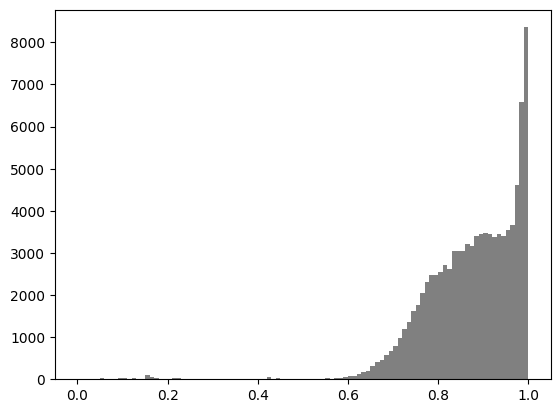

gcbgcb01
Lambda num: 2
Avg, std and var:  0.8737697677589766 0.1068509916963424 0.011417134426491834
New anchor:  0.713493280214463  Area of this anchor:  0.05338897531850481
(0.05338897531850481, 0.04346592103603414, 0.009923054282470672)
remove rate:  0.05338897531850481
gcbgcb02
Lambda num: 2
Avg, std and var:  0.8737697677589766 0.1068509916963424 0.011417134426491834
New anchor:  0.7605077165608537  Area of this anchor:  0.12355463986881386
(0.12355463986881386, 0.10372955472396249, 0.019825085144851373)
remove rate:  0.12355463986881386
gcbgcb03
Lambda num: 2
Avg, std and var:  0.8737697677589766 0.1068509916963424 0.011417134426491834
New anchor:  0.811796192575098  Area of this anchor:  0.2524912752806627
(0.2524912752806627, 0.22305848715469032, 0.02943278812597236)
remove rate:  0.2524912752806627
gcbgcb04
Lambda num: 2
Avg, std and var:  0.8737697677589766 0.1068509916963424 0.011417134426491834


In [12]:
comm = 'gcb'
code = 'gcb'
tgt_dir = './CodeT5/data/comment_update/ASE20/'

split = ['train','valid']
length = []
items = []
for s in split:
    num = 0
    with open(f"../CUPData/dataset/{s}.jsonl", "r+", encoding="utf8") as f:
        for item in f.readlines():
            items.append(json.loads(item))
            num+=1
        length.append(num)
data = pd.DataFrame(items)
data['split'] = ['train']*length[0]+['valid']*length[1]
data = data.rename(columns={'src_desc':'old_comment',"dst_desc":"new_comment",\
                        "src_method":"old_code", "dst_method":"new_code" })
with open(f"cup_semanticsv2.pkl",'rb') as sf:
    semantics = pickle.load(sf)

scores = get_scores(data, semantics,'ase20')


score_list = scores
thresholds = [0.01,0.02,0.03,0.04,0.05,0.06,0.07,0.08,0.09,0.1]

for threshold in thresholds:
    threshold_tag = str(threshold)[str(threshold).index('.')+1:]
    tag = comm+code+threshold_tag
    print(tag)
    a = heuristic_search(score_list, threshold)
    if a == 0.0:
        break
    print('remove rate: ',len([s for s in score_list if s < a])/len(score_list))
threshold = thresholds[thresholds.index(threshold)-1]

In [9]:
for threshold in [0.02]:
    m_values = heuristic_search(scores, threshold)
    refine_data(data, scores, m_values, tgt_dir)

Lambda num: 2
Avg, std and var:  0.8737697677589766 0.1068509916963424 0.011417134426491834
New anchor:  0.7605077165608537  Area of this anchor:  0.12355463986881386
(0.12355463986881386, 0.10372955472396249, 0.019825085144851373)
./CodeT5/data/comment_update/ASE20/
0.7605077165608537


100%|██████████| 11754/11754 [00:03<00:00, 3200.60it/s]
